In [1]:
import sys
sys.path.append("..") ## resetting the path to the parent directory

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
np.random.seed(101)

In [5]:
df = pd.read_csv('../data/balanced_df.csv')

In [6]:
constantine_df = df[df.portrait=='Antoninus Pius']

In [7]:
augustus_df = df[df.portrait=='Diocletian']

In [8]:
frames = [constantine_df,augustus_df]

demo_df = pd.concat(frames).reset_index(drop=True)

In [9]:
demo_df.drop('Unnamed: 0',axis=1,inplace=True)

In [10]:
def filename_appender(df):
    df.fname = df.fname.apply(lambda x: '../img/' + x + '.jpg')
    return df

In [11]:
df = filename_appender(df)
demo_df = filename_appender(demo_df)

In [12]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
demo_df['code'] = LE.fit_transform(demo_df['portrait'])

In [13]:
from sklearn.model_selection import train_test_split

X = demo_df.drop('code',axis=1)

y = demo_df.code

X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.1)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1)

In [14]:
# The format specification here left pads zeros on the number: 0004.
train_filenames = [fname for fname in X_train.fname]
val_filenames = [fname for fname in X_val.fname]
test_filenames = [fname for fname in X_test.fname]

## Preparing datasets
### Finding and deleting corrupted images that Tensorflow cannot handle

In [15]:
def reset_indices(arr):
    arr.reset_index(drop=True,inplace=True)
    return arr

In [16]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [150, 150])
    image /= 255.0
    return image

def remove_corrupt_files(filenames,y_arr):
    imgs = []
    safe_idx = []
    y_arr = reset_indices(y_arr)
    for i,filename in enumerate(filenames):        
        # Try reading, decoding, resizing and normalizing images
        # Only appends files that do not cause any errors to an 'imgs' list
        try:
            img = load_and_preprocess_image(filename)
            imgs.append(np.asarray(img))  
            safe_idx.append(i)
        # If error occurs, skip to the next file and remove the file from the y array using its index
        except:
            
            del y_arr[i]
            continue
              
    X = np.asarray(imgs)
    y = np.asarray(y_arr)
    
    return X, y, safe_idx

In [17]:
X_train,y_train, train_idx = remove_corrupt_files(train_filenames,y_train)
X_val,y_val, val_idx = remove_corrupt_files(val_filenames,y_val)
X_test,y_test, test_idx = remove_corrupt_files(test_filenames,y_test)

## Training the tensorflow model

In [18]:
# from tensorflow.keras import backend as K
# img_width, img_height = 150, 150
# if K.image_data_format() == 'channels_first':
#     input_shape = (3, img_width, img_height)
# else:
#     input_shape = (img_width, img_height, 3)

In [19]:
from tensorflow.keras import backend as K
img_width, img_height = 150, 150
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [20]:
# Change to be committed after fitting is complete
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape=(input_shape), padding='same'))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(96, (3, 3),activation = 'relu', padding='same'))
model.add(keras.layers.Conv2D(96, (3, 3),activation = 'relu', padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))


model.add(keras.layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(keras.layers.Dense(256, activation = 'relu'))
model.add(keras.layers.Dropout(0.8))
model.add(keras.layers.Dense(10, activation = 'softmax'))
#new_model.add(keras.layers.Dense(10,  activation = "softmax"))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 96)        5

In [22]:
optimizer = Adam(lr=0.001)
opt = SGD(lr=0.001, momentum=0.9)

In [23]:
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
from tensorflow.keras import callbacks
my_callbacks = [
    callbacks.EarlyStopping(monitor='loss', mode= 'min', patience=4),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0,
    min_delta=0.001, cooldown=1, min_lr=0, mode = 'min')
]

In [25]:
history = model.fit(X_train, y_train, epochs=100,
         validation_data=(X_val,y_val),callbacks = my_callbacks)

Epoch 1/100
54/54 [==============================] - 99s 2s/step - loss: 1.7235 - accuracy: 0.4704 - val_loss: 0.7181 - val_accuracy: 0.4474 - lr: 0.0010
Epoch 2/100
54/54 [==============================] - 101s 2s/step - loss: 0.8246 - accuracy: 0.5015 - val_loss: 0.7010 - val_accuracy: 0.4474 - lr: 0.0010
Epoch 3/100
54/54 [==============================] - 98s 2s/step - loss: 0.7589 - accuracy: 0.5126 - val_loss: 0.6889 - val_accuracy: 0.5526 - lr: 0.0010
Epoch 4/100
54/54 [==============================] - 202s 4s/step - loss: 0.7484 - accuracy: 0.4892 - val_loss: 0.6909 - val_accuracy: 0.5526 - lr: 0.0010
Epoch 5/100
54/54 [==============================] - 456s 8s/step - loss: 0.7338 - accuracy: 0.5021 - val_loss: 0.6952 - val_accuracy: 0.5526 - lr: 0.0010
Epoch 6/100
54/54 [==============================] - 326s 6s/step - loss: 0.7334 - accuracy: 0.4798 - val_loss: 0.6972 - val_accuracy: 0.4474 - lr: 5.0000e-04
Epoch 7/100
54/54 [==============================] - 107s 2s/step - 

In [26]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print('\nTest accuracy {:5.2f}%'.format(100*test_acc))


Test accuracy 49.29%


## Visualize the model

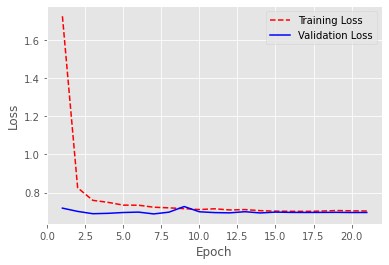

In [27]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

epoch_count = range(1,len(training_loss)+1)

plt.plot(epoch_count,training_loss,'r--')
plt.plot(epoch_count,test_loss,'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

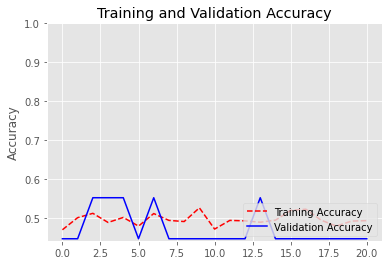

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epoch_count = range(1,len(training_loss)+1)

plt.plot(acc, 'r--', label='Training Accuracy')
plt.plot(val_acc, 'b-', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy');
